In [ ]:
#C1
# Importar librerias

import numpy as np
import matplotlib.pyplot as plt
import time

import keras


# Librerias para la red convolucional
from keras.models import *
from keras.layers import *
from keras.optimizers import *

# Librerias para cargar imagenes

from PIL import Image
import glob

In [ ]:
# C2
# Cargar la base de datos

from google.colab import drive
drive.mount('/content/drive')

# Directorio que contiene las imágenes originales
dir_img = '/content/drive/MyDrive/MARIELA/images_redimension'
# Directorio de salida para las imágenes preprocesadas
dir_lab = '/content/drive/MyDrive/MARIELA/prueba_salida'

image_list = []
label_list = []

background_color = np.array([255, 0, 255])  ## Solo el magenta

for filename in glob.glob('/content/drive/MyDrive/MARIELA/images_redimension/*.png'):
    im=Image.open(filename)
    image_list.append(np.asarray(im))
    #image_list.append(np.asarray(np.expand_dims(im, axis=0)))


    filename1 = filename.replace('images_redimension', 'prueba_salida')
    filename2 = filename1.replace('grieta', 'label_grieta')
    la=Image.open(filename2)

    gt_image = np.asarray(la)
    gt_bg = np.all(gt_image == background_color, axis=2)  #Binarizar la segmentación del target
    label_list.append(np.expand_dims(gt_bg,axis=2))


    #label_list.append(np.asarray(np.expand_dims(la, axis=0)))


print ('Total de imagenes: ', len(image_list))
print ('Total de labels: ', len(label_list))

Mounted at /content/drive
Total de imagenes:  325
Total de labels:  325


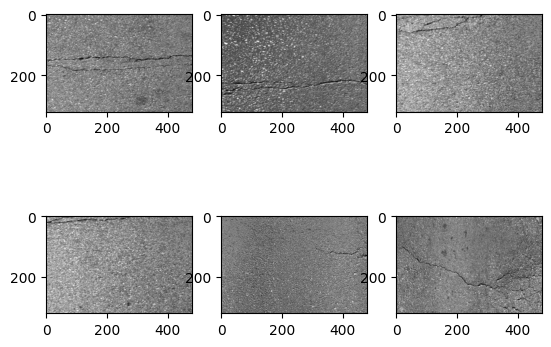

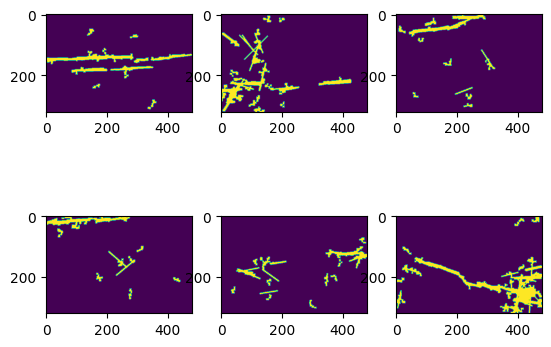

260
65
260
65


In [ ]:
# C3
# Visualizar y acomodar los datos

# Visualizar los datos
fig = plt.figure()
for i in range (0,6):
  a = fig.add_subplot(2,3,i+1)
  plt.imshow(image_list[i])
plt.show()

fig1 = plt.figure()
for j in range (0,6):
  b = fig1.add_subplot(2,3,j+1)
  plt.imshow(label_list[j][:,:,0])
plt.show()


# Separar los datos en conjunto de entrenamiento y prueba

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.20, random_state=40)  # Se requiere el 75% para entrenamiento


print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

In [ ]:
# C4
# Modelo reducido

# Modelo: U-Net-B
input_size = (320,480,3)

def unetB(input_size = (320,480,3)):

    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(s)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)


    convT3 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([convT3, conv4], axis=3)
    conv15 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge3)
    conv16 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv15)

    convT4 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv16))
    merge4 = concatenate([convT4, conv2], axis=3)
    conv17 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge4)
    conv18 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv17)


    y = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    return Model(inputs=inputs, outputs=y)

model = unetB(input_size)

model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 480, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 320, 480, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 320, 480, 64)         1792      ['lambda_1[0][0]']            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 320, 480, 64)         36928     ['conv2d_13[0][0]']           
                                                                                            

In [ ]:
# C5
# Entrenar el modelo

log=model.fit(x=np.array(X_train)
          ,y=np.array(y_train)
          ,epochs=50      # Definir el numero de epocas para el entrenamiento
          ,batch_size=2
          ,validation_data=(np.array(X_test),np.array(y_test)))

Epoch 1/50
130/130 [==============================] - 7s 31ms/step - loss: 0.2631 - accuracy: 0.9257 - val_loss: 0.2524 - val_accuracy: 0.9284
Epoch 2/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2474 - accuracy: 0.9323 - val_loss: 0.2599 - val_accuracy: 0.9284
Epoch 3/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2434 - accuracy: 0.9324 - val_loss: 0.2737 - val_accuracy: 0.9287
Epoch 4/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2464 - accuracy: 0.9317 - val_loss: 0.2588 - val_accuracy: 0.9284
Epoch 5/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2413 - accuracy: 0.9322 - val_loss: 0.2465 - val_accuracy: 0.9284
Epoch 6/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2340 - accuracy: 0.9325 - val_loss: 0.2547 - val_accuracy: 0.9285
Epoch 7/50
130/130 [==============================] - 4s 29ms/step - loss: 0.2320 - accuracy: 0.9327 - val_loss: 0.2321 - val_accuracy: 0.9297

1/1 [==============================] - 0s 24ms/step
Tiempo de ejecucion:  0.07042622566223145


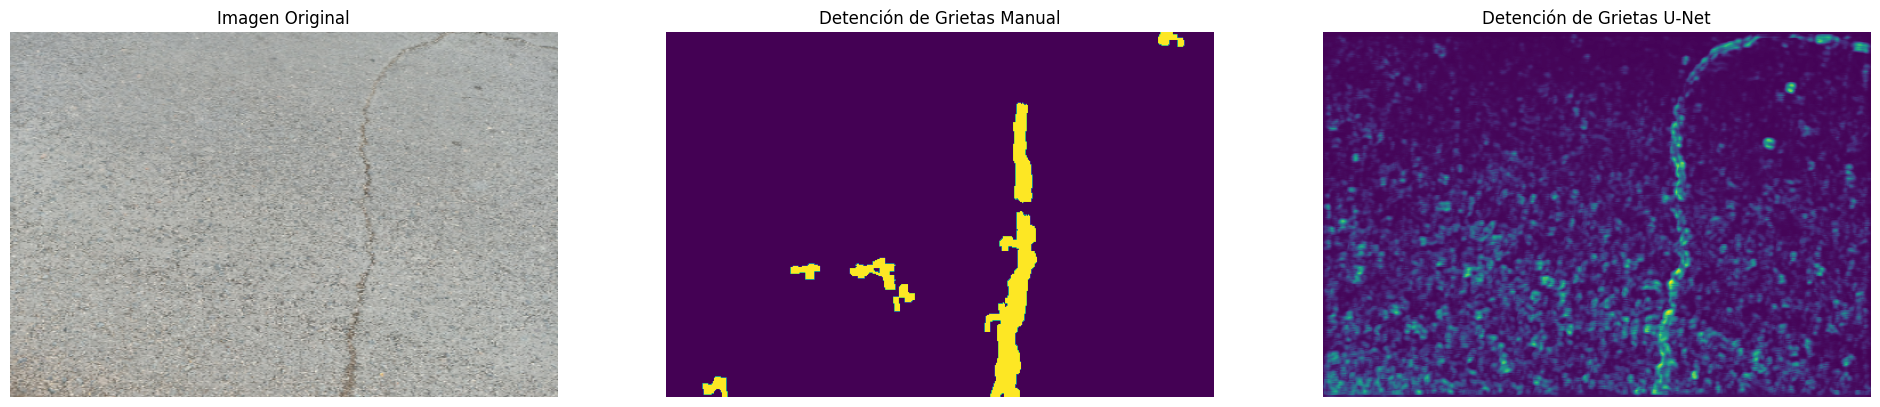

In [ ]:
# C6
# Probar el modelo con una sola imagen

t_l = y_test [5]
t1 = t_l[:,:,0]


inicio = time.time()
pred = model.predict(np.expand_dims(X_test[5],axis=0))
fin = time.time()
print ('Tiempo de ejecucion: ', fin-inicio)

plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.imshow(X_test[5])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(t1)
plt.title('Detención de Grietas Manual')
plt.axis('off')

plt.subplot(133)
plt.imshow(pred[0,:,:,0])
plt.title('Detención de Grietas U-Net')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 165ms/step
Tiempo de ejecucion:  0.2114086151123047


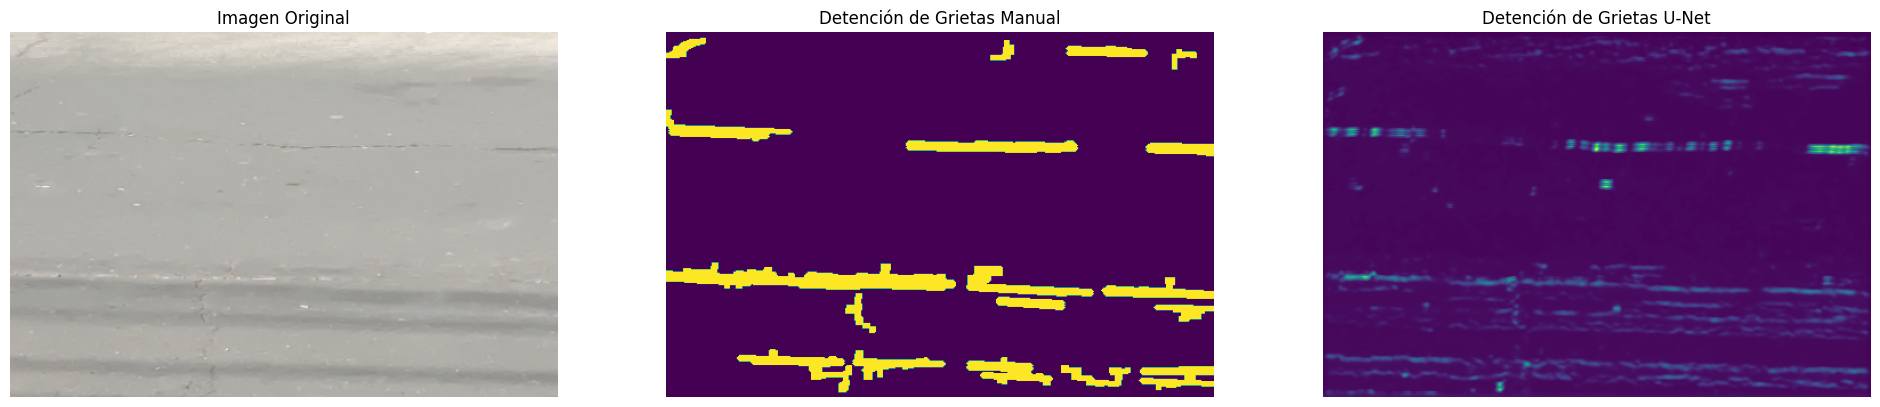

In [ ]:
# C6
# Probar el modelo con una sola imagen

t_l = y_test [39]
t1 = t_l[:,:,0]


inicio = time.time()
pred = model.predict(np.expand_dims(X_test[39],axis=0))
fin = time.time()
print ('Tiempo de ejecucion: ', fin-inicio)

plt.figure(figsize=(24, 6))

plt.subplot(131)
plt.imshow(X_test[39])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(t1)
plt.title('Detención de Grietas Manual')
plt.axis('off')

plt.subplot(133)
plt.imshow(pred[0,:,:,0])
plt.title('Detención de Grietas U-Net')
plt.axis('off')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

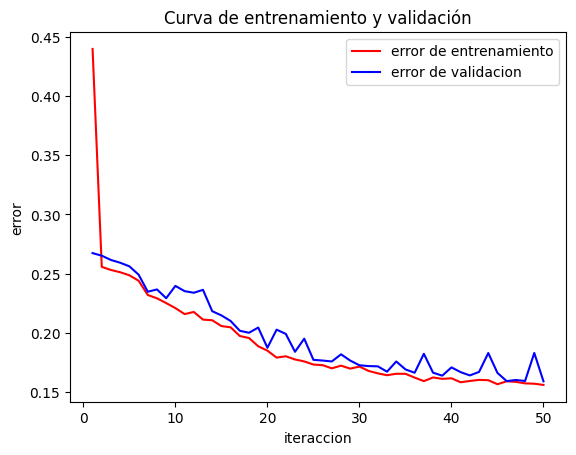

In [ ]:
error=log.history['loss']
val_error=log.history['val_loss']
epochs=range(1,len(error)+1)
plt.plot(epochs,error,color='red',label='error de entrenamiento')
plt.plot(epochs,val_error,color='blue',label='error de validacion')
plt.title('Curva de entrenamiento y validación')
plt.xlabel('iteraccion')
plt.ylabel('error')
plt.legend()
plt.show

3/3 [==============================] - 24s 524ms/step
True Positives: 255376 ( 35.853618130101616 %)
False Positives: 111451 ( 1.2020523471034412 %)
True Negatives: 9160275 ( 98.79794765289655 %)
False Negatives: 456898 ( 64.14638186989838 %)
Precision: 0.6961755814048585
Recall: 0.35853618130101617


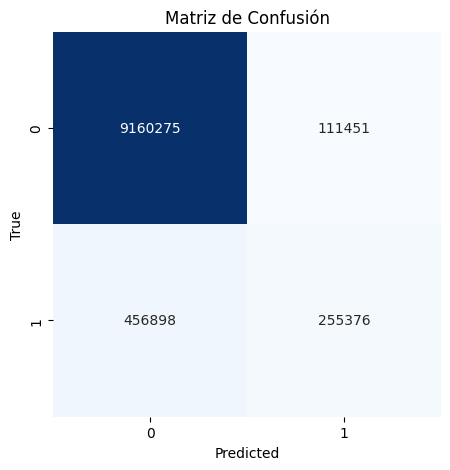

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(np.array(X_test))

# Redondear las predicciones a 0 o 1 (ya que es un problema de clasificación binaria)
y_pred_binary = np.round(y_pred).ravel()

# Convertir las etiquetas del conjunto de prueba a formato binario
y_test_binary = np.round(y_test).ravel()

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Calcular los valores de interés
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

# Calcular precision y recall
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

# Calcular porcentajes
total_samples = len(y_test_binary)
total_positives = true_positive + false_negative
total_negatives = true_negative + false_positive

percent_true_positive = (true_positive / total_positives) * 100
percent_false_positive = (false_positive / total_negatives) * 100
percent_true_negative = (true_negative / total_negatives) * 100
percent_false_negative = (false_negative / total_positives) * 100

# Mostrar los valores en la consola
print("True Positives:", true_positive, "(", percent_true_positive, "%)")
print("False Positives:", false_positive, "(", percent_false_positive, "%)")
print("True Negatives:", true_negative, "(", percent_true_negative, "%)")
print("False Negatives:", false_negative, "(", percent_false_negative, "%)")

print("Precision:", precision)
print("Recall:", recall)

# Mostrar la matriz de confusión como un gráfico de calor
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()
